In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
notes = pd.read_parquet('rated_notes_compact.parquet', engine='auto')

In [3]:
# clumn names
notes.columns

Index(['noteId', 'finalRatingStatus', 'firstTag', 'secondTag',
       'classification', 'createdAtMillis', 'numRatings', 'noteTopic',
       'topicNoteConfident', 'noteAuthorParticipantId', 'tweetId',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote'],
      dtype='object')

In [4]:
# number of rated notes
len(notes)

175861

check assigned topics

In [5]:
notes['noteTopic'].value_counts()

noteTopic
GazaConflict       9540
UkraineConflict    5970
MessiRonaldo        514
Name: count, dtype: int64

In [6]:
notes['noteTopic'].unique()

array([None, 'GazaConflict', 'UkraineConflict', 'MessiRonaldo'],
      dtype=object)

check how many does not have an assigned topic

In [7]:
len(notes[notes['noteTopic'].values == None])

159837

Most of them does not have an assigned topic! Let's see 10 random note without a topic!


In [8]:
notes[notes['noteTopic'].values == None]['summary'].sample(n=10)

159790    Misinformation!  The police have clarified tha...
151108    Esta cuenta no es la oficial que usan para Squ...
9981      Contrails are formed when water vapour and fin...
27500     The latest public release of MacOS is MacOS 14...
67707                                                  None
127393    Information trompeuse, aucune enquête du FBI e...
8123      This is completely made up. An article in the ...
17778     Grupo Bimbo ha dado a conocer que esta campaña...
122475    NNN    The original post didn’t mention when t...
58071     Your keyboard does not have this functionality...
Name: summary, dtype: object

It seems like most of them are not in English! Plus, some of them are None! Let's remove the None s and detect the language the notes were written in!

In [9]:
notes = notes[notes['summary'].notna()]

In [10]:
len(notes)

159226

In [11]:
# using detect function from langdetect to create a new column for languages
langs = []
for note in notes['summary']:
    try:
        langs.append(detect(note))
    # except LangDetectException:
    #     print(f"LangDetectException for note: {note}")
    #     langs.append(None)
    except Exception as error:
    # handle the exception
        print("An exception occurred:", error) 
        print(note)
        langs.append(None)

An exception occurred: No features in text.
🖕🖕🖕🖕🖕🖕
An exception occurred: No features in text.
http://www.shadowstats.com/alternate_data/inflation-charts
An exception occurred: No features in text.
🫡
An exception occurred: No features in text.
🔥 🐶☕ 🔥
An exception occurred: No features in text.
.
An exception occurred: No features in text.
https://www.mhlw.go.jp/stf/seisakunitsuite/bunya/vaccine_pfizer_bivalent.html#002
An exception occurred: No features in text.
https://sites.imsa.edu/acronym/2021/03/04/elon-musk-is-not-an-entrepreneur-hes-a-rich-deceitful-hack/  https://www.cnbc.com/2018/06/01/elon-musks-mom-worked-5-jobs-to-raise-3-kids-after-her-divorce.html  https://www.cnbc.com/2018/06/12/telsas-elon-musk-tweets-he-arrived-in-north-america-at-17-with-2000.html  
An exception occurred: No features in text.
https://twitter.com/horacioneiva/status/1658638214385614852?s=20
An exception occurred: No features in text.
https://www.washingtonpost.com/politics/2021/03/19/how-spot-fake-vide

In [22]:
notes['language'] = langs
# update the saved dataframe
notes.to_parquet('rated_notes_compact.parquet')

There are some notes without a language. They may contain external links, emojis, numbers, punctuation marks or a mixture of them.

In [3]:
# How many of them contain non-language communications?
sum(notes['language'].isnull())

#TODO needs further analysis to separate all instances or just check if those were helpful at all (since there are very few of them)

120

In [4]:
print(f"There are notes from {notes['language'].nunique()} languages.")

There are notes from 47 languages.


Let's see the distribution of languages of the note with more than 1% of the total

<Axes: xlabel='language'>

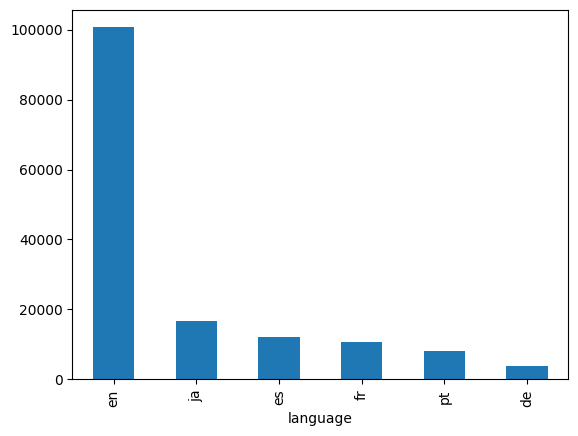

In [23]:
# notes['language'].hist()
# more popular languages 
pop_langs = notes['language'].value_counts()[notes['language'].value_counts() > .01*len(notes)].index

notes[notes['language'].isin(pop_langs)]['language'].value_counts().plot(kind='bar')

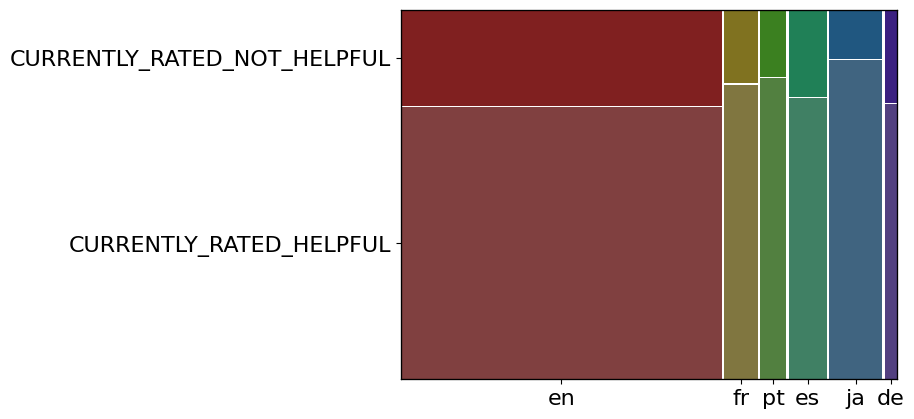

In [35]:
# compare labels of helpfulness between languages.
# plt.rcParams['font.size'] = 16 
mosaic(notes[notes['language'].isin(pop_langs)],
    ['language', 'finalRatingStatus'], labelizer=lambda k: '');

In [74]:
# The helpfulness level does not seem to be that different. Let's see!
helfulness_langs = notes[notes['language'].isin(pop_langs)] \
    .groupby(['language', 'finalRatingStatus']) \
    .count().reset_index()[['language', 'finalRatingStatus','noteId']]
# rename noteID
helfulness_langs.rename(columns={'noteId': 'count'}, inplace=True)

def percentage_lang(row):
    return (row['count'] / \
        helfulness_langs[helfulness_langs['language'] == row['language']]['count'].sum()
        * 100)
helfulness_langs['percent'] = helfulness_langs.apply(percentage_lang, axis=1)
helfulness_langs[helfulness_langs['finalRatingStatus'] == 'CURRENTLY_RATED_HELPFUL']

,language,finalRatingStatus,count,percent
0,de,CURRENTLY_RATED_HELPFUL,2870,74.778530
2,en,CURRENTLY_RATED_HELPFUL,74290,73.794104
4,es,CURRENTLY_RATED_HELPFUL,9187,76.386464
6,fr,CURRENTLY_RATED_HELPFUL,8479,79.975476
8,ja,CURRENTLY_RATED_HELPFUL,14440,86.711103
10,pt,CURRENTLY_RATED_HELPFUL,6596,81.694327


The majority of notes are in english. Let's focus on them.

In [63]:
df_eng = notes[notes['language'] == 'en']
